# Audio Sensor Test

First import some libraries that are used and then query the audio devices available

In [1]:
# Import libraries
import sounddevice as sd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import librosa

print(sd.query_devices())

fs = 48000  # sampling rate
seconds = 6  # duration 

   0 Microsoft Sound Mapper - Input, MME (2 in, 0 out)
>  1 Microphone (AudioHubNano2D_V1.5, MME (2 in, 0 out)
   2 Desktop Microphone (4- Microsof, MME (2 in, 0 out)
   3 Analogue 1 + 2 (Focusrite Usb A, MME (2 in, 0 out)
   4 Microsoft Sound Mapper - Output, MME (0 in, 2 out)
<  5 AG271QG4 (NVIDIA High Definitio, MME (0 in, 2 out)
   6 Speakers (Focusrite Usb Audio), MME (0 in, 2 out)
   7 Realtek Digital Output (2- Real, MME (0 in, 2 out)
   8 Primary Sound Capture Driver, Windows DirectSound (2 in, 0 out)
   9 Microphone (AudioHubNano2D_V1.5), Windows DirectSound (2 in, 0 out)
  10 Desktop Microphone (4- Microsoft® LifeCam HD-3000), Windows DirectSound (2 in, 0 out)
  11 Analogue 1 + 2 (Focusrite Usb Audio), Windows DirectSound (2 in, 0 out)
  12 Primary Sound Driver, Windows DirectSound (0 in, 2 out)
  13 AG271QG4 (NVIDIA High Definition Audio), Windows DirectSound (0 in, 2 out)
  14 Speakers (Focusrite Usb Audio), Windows DirectSound (0 in, 2 out)
  15 Realtek Digital Output (2- 

Now record some audio and save to file

In [19]:
from scipy.io.wavfile import write

sd.default.device = 4 # Set device

# Record audio
print("Recording...")
myrecording = sd.rec(int(seconds * fs), samplerate=fs, channels=2, dtype='float64')
sd.wait()  # Wait for the recording to finish
print("Recording complete")

# Ignore the first second of the recording (fs * 1 second to skip)
myrecording = myrecording[int(fs*1):, :] 
myrecording_normalised = myrecording / np.max(np.abs(myrecording))

# Save the recording as a wav file
print("Writing wav...")
write('output.wav', fs, myrecording)  
print("Writing wav complete")

Recording...
Recording complete
Writing wav...
Writing wav complete


Read in some audio (if required) and play

In [2]:
from scipy.io.wavfile import read

file_name = 'output_env.wav'
file_name = 'output_click.wav'
# file_name = 'output.wav'
fs, myrecording = read(file_name)
myrecording_normalised = myrecording / np.max(np.abs(myrecording))
print('Sample rate:', fs)

# Switch to default output device
sd.default.device = 32

# Play the recorded sound
print("Playing recorded sound...")
sd.play(myrecording_normalised, fs)
sd.wait()  # Wait for the audio to finish playing
print("Playback complete")

Sample rate: 48000
Playing recorded sound...
Playback complete


Plot in time and time/frequency

Maximum Magnitude (Left Channel): 0.00 dB
Maximum Magnitude (Right Channel): 0.00 dB


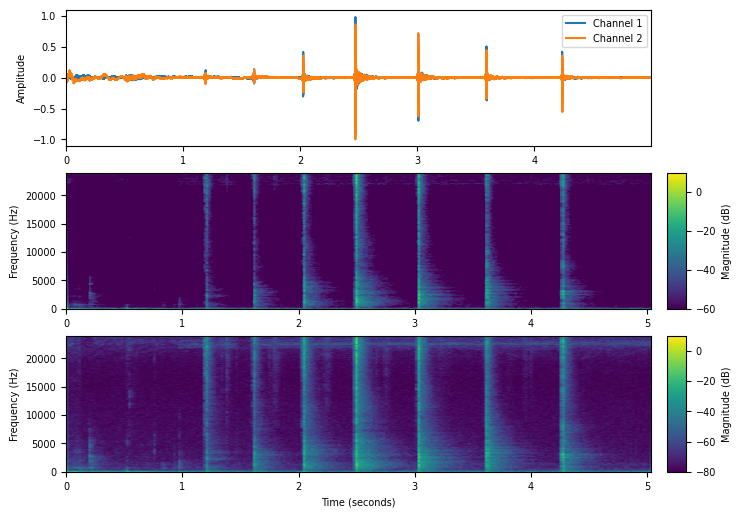

In [3]:
H = 1024
N = 2048
w = np.hanning(N)
X1 = librosa.stft(myrecording_normalised[:, 0], window=w, hop_length=H)
X2 = librosa.stft(myrecording_normalised[:, 1], window=w, hop_length=H)
Y1 = np.abs(X1) ** 2
Y2 = np.abs(X2) ** 2
eps = np.finfo(float).eps
Y1_db = librosa.amplitude_to_db(np.abs(X1), ref=np.max)
Y2_db = librosa.amplitude_to_db(np.abs(X2), ref=np.max)

T_coef1 = np.arange(X1.shape[1]) * H / fs
F_coef1 = np.arange(X1.shape[0]) * fs / N
T_coef2 = np.arange(X2.shape[1]) * H / fs
F_coef2 = np.arange(X2.shape[0]) * fs / N

fig = plt.figure(figsize=(8, 6))

gs = gridspec.GridSpec(3, 2, width_ratios=[6, 0.2], wspace=0.05)
ax1, ax2, ax3, ax4, ax5, ax6 = [plt.subplot(gs[i]) for i in range(6)]

t = np.arange(len(myrecording_normalised)) / fs
ax1.plot(t, myrecording_normalised[:, 0], label="Channel 1")  
ax1.plot(t, myrecording_normalised[:, 1], label="Channel 2")
ax1.tick_params(labelsize=7)  
ax1.set_xlim([min(t), max(t)])
ax1.set_ylim([-1.1, 1.1])
ax1.legend(fontsize=7)
ax1.set_ylabel("Amplitude", fontsize=7)

ax2.set_visible(False)

left1 = min(T_coef1)
right1 = max(T_coef1) + N / fs
lower1 = min(F_coef1)
upper1 = max(F_coef1)

im1 = ax3.imshow(Y1_db, origin='lower', aspect='auto', 
                 extent=[left1, right1, lower1, upper1])
im1.set_clim([-60, 10])
ax3.set_ylim([0, 24000])
ax3.set_ylabel('Frequency (Hz)', fontsize=7)
ax3.tick_params(labelsize=7)  
cbar = fig.colorbar(im1, cax=ax4)
cbar.ax.tick_params(labelsize=7) 
ax4.set_ylabel('Magnitude (dB)', rotation=90, size=7)

left2 = min(T_coef2)
right2 = max(T_coef2) + N / fs
lower2 = min(F_coef2)
upper2 = max(F_coef2)

im2 = ax5.imshow(Y2_db, origin='lower', aspect='auto', 
                 extent=[left2, right2, lower2, upper2])
im2.set_clim([-80, 10])
ax5.set_ylim([0, 24000])
ax5.set_xlabel('Time (seconds)', fontsize=7)
ax5.set_ylabel('Frequency (Hz)', fontsize=7)
ax5.tick_params(labelsize=7)  
cbar = fig.colorbar(im2, cax=ax6)
cbar.ax.tick_params(labelsize=7)  
ax6.set_ylabel('Magnitude (dB)', rotation=90, size=7)

# Calculate and print the maximum magnitudes for left and right channels
max_magnitude_left = np.max(Y1_db)
max_magnitude_right = np.max(Y2_db)
print(f"Maximum Magnitude (Left Channel): {max_magnitude_left:.2f} dB")
print(f"Maximum Magnitude (Right Channel): {max_magnitude_right:.2f} dB")

# plt.tight_layout()

Cross correlation

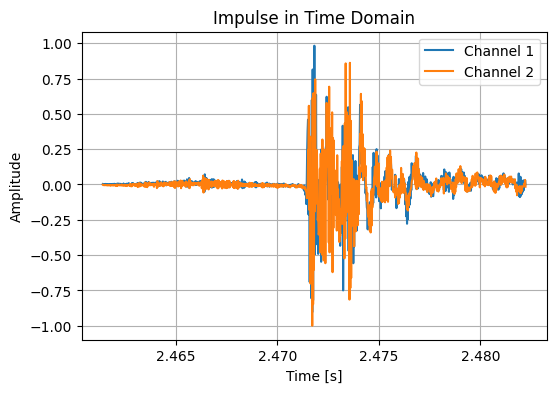

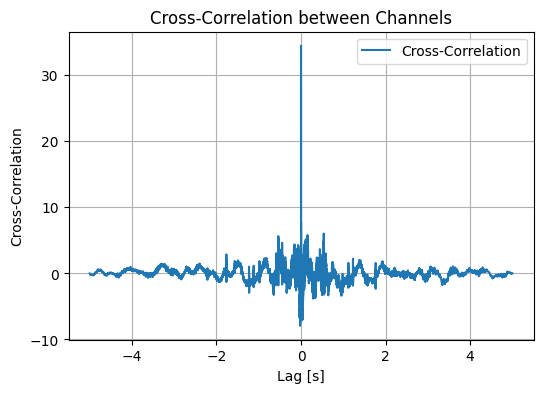

Delay: -4.1666666666666665e-05 seconds
Spatial Nyquist frequency: 7999.067164179104 Hz
Angle of Arrival: -41.80433955608707 degrees


In [4]:
from scipy import signal

channel_1 = myrecording_normalised[:, 0]
channel_2 = myrecording_normalised[:, 1]

# find the sample with the maximum absolute value
impulse_index = np.argmax(np.abs(channel_1))

# extract a window of 1000 samples around the impulse
window_size = 1000
impulse_L = channel_1[impulse_index-window_size//2 : impulse_index+window_size//2]
impulse_R = channel_2[impulse_index-window_size//2 : impulse_index+window_size//2]
impulse_time = np.linspace((impulse_index-window_size//2)/fs, (impulse_index+window_size//2)/fs, window_size)

# Plot the impulse
plt.figure(figsize=(6, 4))
plt.plot(impulse_time, impulse_L, label="Channel 1")  
plt.plot(impulse_time, impulse_R, label="Channel 2")  
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("Impulse in Time Domain")
plt.grid(True)
plt.legend()
plt.show()

# Compute the cross-correlation
corr = signal.correlate(channel_1, channel_2, mode='full', method='auto')

# Create an array representing the lag times
lags = signal.correlation_lags(len(channel_1), len(channel_2), mode='full')
lag_time = lags / fs # Convert lags to time

# Plot the cross-correlation
plt.figure(figsize=(6, 4))
plt.plot(lag_time, corr, label="Cross-Correlation")
plt.xlabel("Lag [s]")
plt.ylabel("Cross-Correlation")
plt.title("Cross-Correlation between Channels")
plt.grid(True)
plt.legend()
plt.show()

# Find the delay
delay_samples = corr.argmax() - (len(channel_1) - 1)
delay_seconds = delay_samples / fs

print(f"Delay: {delay_seconds} seconds")

d = 2.144 / 100 # distance between the microphones in meters
speed_of_sound = 343  # speed of sound in m/s
angle_of_arrival = np.arcsin(delay_seconds * speed_of_sound / d)
f_Nyquist = speed_of_sound / (2 * d) 
print(f"Spatial Nyquist frequency: {f_Nyquist} Hz")
print(f"Angle of Arrival: {np.degrees(angle_of_arrival)} degrees")